<a href="https://colab.research.google.com/github/KAUZHAL/Quantum_project/blob/main/Quantum_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.1 MB/s eta 0:00:00


In [6]:
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 51.0 MB/s eta 0:00:00


In [7]:
from google.colab import files
uploaded=files.upload()

Saving passwords.txt to passwords (1).txt


In [8]:
with open("passwords.txt", "r") as file:
    passwords=file.read().strip().split()
if len(passwords)<32:
    raise ValueError("Need at least 32 passwords in passwords.txt")
passwords = passwords[:32]
# target password needs to be chosen
target_index=16
target_password=passwords[target_index]
print(f"Target password selected:{target_password}(index {target_index})")

Target password selected: Mamtarawat (index 16)


In [9]:
from qiskit import QuantumCircuit
def grover_oracle(target_index,num_qubits): #function to build an oracle that flips the sign of target state
    oracle=QuantumCircuit(num_qubits) #creates a circult with the number of qubits
    binary_str=format(target_index,f'0{num_qubits}b') #converts target_index to binary string which is padded uptil number of qubits provided
    for i,bit in enumerate(reversed(binary_str)):
        if bit=='0':
            oracle.x(i) #applying NOT gate on all '0' qubits to construct the control for matching the target state
    oracle.h(num_qubits - 1)  #applying hadamard gate to last qubit
    oracle.mcx(list(range(num_qubits-1)),num_qubits-1)  #applying toffoli generalization to flip the last qubit only if all other qubits match the target
    oracle.h(num_qubits-1) #undoing the hadamard gate
    for i,bit in enumerate(reversed(binary_str)):
        if bit=='0':
            oracle.x(i) #undoing the NOT gate
    return oracle

In [10]:
def diffusion_operator(num_qubits): #function to create a diffusion operator which amplifies the probability of target state
    diffuser=QuantumCircuit(num_qubits) #another circuit
    diffuser.h(range(num_qubits)) #applying hadamard gate to create uniform superposition
    diffuser.x(range(num_qubits)) #applying NOT gate to invert about zero
    diffuser.h(num_qubits-1)                              # this may look similar to Oracle's code but it is a new gate
    diffuser.mcx(list(range(num_qubits-1)),num_qubits-1)  # called Multi-controlled Z gate which applies phase-flip to the
    diffuser.h(num_qubits-1)                              # target qubit only when all control qubits are in the state |1⟩
    diffuser.x(range(num_qubits)) #undoing X gate
    diffuser.h(range(num_qubits)) #undoing hadamard gate
    return diffuser

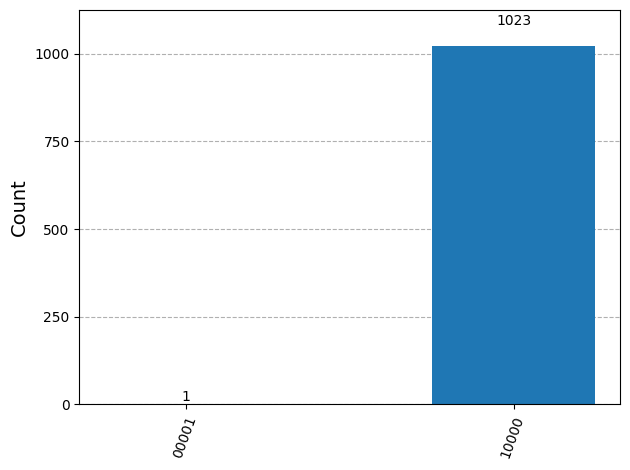

In [11]:
from qiskit_aer import AerSimulator #AerSimulator is for circuit execution
from qiskit import transpile #to optimize the circuit for the backend

num_qubits=5
oracle=grover_oracle(target_index, num_qubits)
diffuser=diffusion_operator(num_qubits)
grover_circuit=QuantumCircuit(num_qubits, num_qubits) #creating final circuit with 5 quantum and 5 classical bits
grover_circuit.h(range(num_qubits)) #applying hadamard gate to put all qubits in unifor superposition
import math
iterations = int(math.pi/4*math.sqrt(2**num_qubits)) #optimal number of grover iterations-->π/4*sqrt(N)
for _ in range(iterations):#applying Grover iterations
    grover_circuit.compose(oracle,inplace=True) #applying oracle to mark the target state
    grover_circuit.compose(diffuser,inplace=True) #applying diffusor to amplify it
grover_circuit.measure(range(num_qubits),range(num_qubits)) #measuring each qubit to store the result in classical bit
# Simulating
sim = AerSimulator()
compiled_circuit=transpile(grover_circuit,sim)
result=sim.run(compiled_circuit).result()
counts=result.get_counts() #retrieves measurement results as a dictionary of {bitstring:count}

from qiskit.visualization import plot_histogram
plot_histogram(counts)